# Autoregressive model using a feedforward neural network (pytorch implementation)

In this notebook we will use a feedforward neural network to fit a linear model to time series data. 

> In this notebook all models are implemented with pytorch.

<div class="alert alert-success">
    
1. Pytorch has an excellent, but slightly more involved interface than Keras provides for Tensorflow.  
    
2. The data preprocessing requirements for a NN are similar to those for Keras and TensorFlow, but there are additional steps needed regarding mini batches and make sure data are tensors.

2. Forecasting **h-steps** ahead uses the same approach as Keras/Tensorflow, but there are subtle differences in the code.
</div>

---
**LEARNING OBJECTIVES**

* Use a NN to mimic a linear model using PyTorch.
* Train a deep learning model implemented using PyTorch.
* Generate h-step forecasts using an iterative approach
* Generate h-step forecast using a direct modelling approach
* Construct a deep feedforward neural network for forecasting
* Use a ensemble of neural networks to forecast
---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work. We are going to implement neural networks using `pytorch`. You should be using at least `pytorch` version `1.4.0`.

In [1]:
#import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import time

torch.__version__

'1.10.0'

## 2. Reminder: The forecasting process for AR

1. Select $l$ the number of autoregressive lags and forecast horizon $h$
2. Pre-process the data into tabular form [[$lag_1, lag_2, ... lag_l$], [$y_t$]]
3. Train the NN model using the tabular data
4. Iteratively forecast 1-step ahead gradually replacing ground truth observations with predictions.


### 2.1 Synthetic data without noise

Given the extra complexities of forecasting using OLS we will use simple synthetic data before exploring real healthcare data. The synthetic data we will use is a cosine.  

In [2]:
t = np.arange(200)
ts_data = np.cos(0.2 * t)

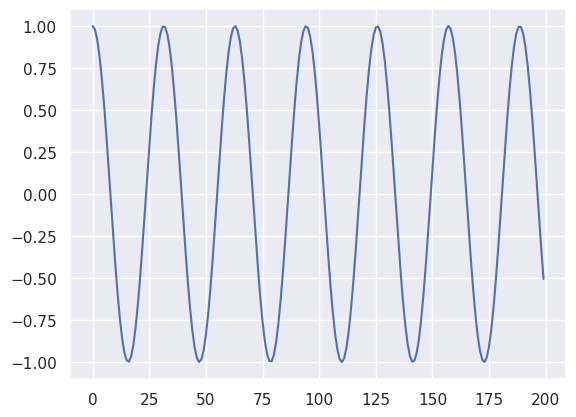

In [3]:
plt.plot(ts_data);

## 2.2. Preprocess the time series into tabular autoregressive form

An autoregressive model consists of $l$ lags of the time series. 

An easy way to think about the form of the data for a autoregressive OLS model is as a table of variables.  The first $l$ columns are the lags (the independent predictor variables) and the final column is $y$ at time $t$ ($y_t$) that is, the target/dependent variable.  

We there need to manipulate the time series so that is now in that format.  More precisely for each row we need: 

**A vector presenting the lags at time t**
* $X_t = $ [$lag_{t-l}, ... lag_{t-2}, lag_{t-1}$]

**A scalar value representing y at time t:**
* $y_t$

For training we need a vector of rows ($X_t$) and vector of target $y_t$. e.g.

```python
X_train = [X_1, X_2, X_3, ...,  X_t]

y_train = [y_1, y_2, y_3, ..., y_t]
```
---

The function `sliding_window` illustrates how to preprocess time series data into tabular form  in python.

In [4]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, )

In [5]:
def to_tensors(*arrays):
    results = ()
    for a in arrays:
        results += torch.FloatTensor(a),
    return results

In [6]:
def get_data_loader(X, y, batch_size=32):
    '''
    Set up train data as a TensorDataSet
    '''
    tensor_data = TensorDataset(torch.FloatTensor(X),
                                torch.FloatTensor(y))

    return DataLoader(tensor_data, 
                      batch_size=batch_size, 
                      shuffle=False)

In [7]:
def ts_train_test_split(*arrays, train_size, as_tensors=True):
    '''
    time series train test split
    
    Parameters:
    X: array-like
        X data
    y_data 
    '''
    results = ()
    for a in arrays:
        if as_tensors:
            results += to_tensors(a[:train_size], a[train_size:])
        else:
            results += a[:train_size], a[train_size:]

    return results

In [8]:
WINDOW_SIZE = 5
BATCH_SIZE = 16

# preprocess time series into a supervised learning problem
X_data, y_data = sliding_window(ts_data, window_size=WINDOW_SIZE)

# train test split
train_size = int(len(y_data) * (2/3))
X_train, X_test, y_train, y_test = ts_train_test_split(X_data, 
                                                y_data,
                                                train_size=train_size,
                                                as_tensors=True)

## 2.3 Create the PyTorch model.

After pre-processing the data, we need to create our PyTorch model.  The first model we create will mimic the linear autoregressive model we built using an instance of `OLS`. This means we have neural network with a single layer with `window_size` inputs ans a single output.  

In [9]:
# Base model on PyTorch nn.Module class
class LinearModel(nn.Module):
    def __init__(self, window_size):
        # Inherit parent (nn.module) methods using super init
        super(LinearModel, self).__init__()
        # Linear model only has a single layer 
        # window_size input containing our lags
        # a Linear object is the same as Keras' Dense layer.
        self.layer1 = nn.Linear(in_features=window_size, 
                                out_features=1, 
                                bias=True)   
        
    def forward(self, x):
        # Pass data through net. 
        y_pred = self.layer1(x)
        return y_pred

In [10]:
def fit(model, optimizer, criterion, n_epochs, 
        X_train, y_train, X_test=None, y_test=None, 
        batch_size=32, verbose=0):
    '''
    train the pytorch model 
    
    Parameters:
    ------
    model: torch.nn.module
        PyTorch Neural Network Model implements .forward()
    
    optimizer: torch.optim.Optimizer
        PyTorch optimization engine e.g. Adam
        
    criterion: torch.nn.criterion
        PyTorch criterion e.g. MSELoss 
        
    n_epochs: int
        Number of epochs to train
        
    X_train: Tensor
        x training matrix 2D
        
    y_train: Tensor
        y training vector
        
    X_test: Tensor, optional (default=None)
        x test matrix 2D
        
    y_test: Tensor, optional (default=None)
        y test vector
        
    batch_size: int, optional (default=32)
        Size of the mini batches used in training
        
    verbose: int, optional (default=0)
        0 == no output during training
        1 == output loss every 10 epochs 
        (includes validation loss if X_test, y_test included)
    
    Returns:
    -------
        dict
        training and validation loss history. keys are
        'loss' and 'val_loss'
    '''
    PRINT_STEPS = 10

    # Set up lists for loss
    train_losses = []
    test_losses = []

    history = {'loss':[],
               'val_loss':[]}

    # create the mini-batches
    train_loader = get_data_loader(X_train, 
                               y_train, 
                               batch_size=batch_size)
    start_time = time.time()
    
    # Loop through required number of epochs
    for epoch in range(n_epochs):
        # Train model (using batches): Switch to training mode
        model.train()
        for batch in train_loader:
            
            y_pred = model.forward(batch[0])
            loss = criterion(y_pred, batch[1].reshape(y_pred.shape[0], -1))

            # Zero gradients, perform a backward pass,  
            # and update the weights. 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

        # Get results for complete training set: Switch to evaluation mode
        model.eval()
        y_pred_train = model.forward(X_train)
        history['loss'].append(criterion(y_pred_train, 
                                         y_train.reshape(y_pred_train.shape[0], 
                                                         -1)).detach())

        if not X_test is None:
            # Get results for test set
            y_pred_test = model.forward(X_test)
            history['val_loss'].append(criterion(y_pred_test, 
                                                 y_test.reshape(y_pred_test.shape[0], 
                                                                -1)).detach())

        # Print loss & accuracy every 10 epochs (prt last item of results list)
        if verbose == 1:
            if (epoch+1) % PRINT_STEPS == 0:
                print(f'Epoch {epoch+1}. ', end='')
                print(f"Train accuracy {history['loss'][-1]: 0.3f}. ", end='')
                print(f"Test accuracy {history['val_loss'][-1]: 0.3f}.")

    duration = time.time() - start_time
    if verbose == 1:
        print(f'Training time {duration:.2f}s')
    
    return history

In [11]:
torch.manual_seed(1234)

N_EPOCHS = 100

# Create model
model = LinearModel(WINDOW_SIZE)
# Set loss 
criterion = nn.MSELoss()
# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

history = fit(model, optimizer, criterion, N_EPOCHS, 
              X_train, y_train, X_test=X_test, y_test=y_test, 
              batch_size=32, verbose=1)

Epoch 10. Train accuracy  0.180. Test accuracy  0.184.
Epoch 20. Train accuracy  0.101. Test accuracy  0.103.
Epoch 30. Train accuracy  0.055. Test accuracy  0.056.
Epoch 40. Train accuracy  0.027. Test accuracy  0.027.
Epoch 50. Train accuracy  0.012. Test accuracy  0.012.
Epoch 60. Train accuracy  0.005. Test accuracy  0.005.
Epoch 70. Train accuracy  0.002. Test accuracy  0.002.
Epoch 80. Train accuracy  0.000. Test accuracy  0.001.
Epoch 90. Train accuracy  0.000. Test accuracy  0.000.
Epoch 100. Train accuracy  0.000. Test accuracy  0.000.
Training time 0.12s


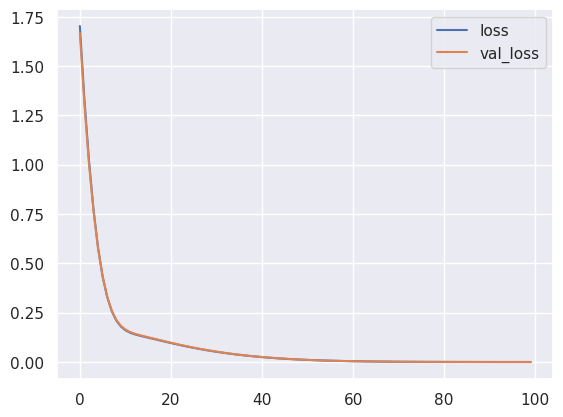

In [12]:
plt.plot(range(N_EPOCHS), history['loss'], label='loss')
plt.plot(range(N_EPOCHS), history['val_loss'], label='val_loss')
plt.legend()

## 2.4 Forecasting 1 step ahead

To forecast 1-step ahead we use the just need to pass tbe first element of the `X_test` tensor to the model. 

In [13]:
with torch.no_grad():
    pred = model(X_test[0])[0]

In [14]:
print(f'1-step forecast: {pred:10.4f}')
print(f'ground trust value: {y_test[0]:6.4f}')

1-step forecast:    -0.0912
ground trust value: -0.0963


## 2.4 Forecast h periods ahead using the iterative method.

**We have trained our `NN` model to predict 1-step**. When forecasting 2 or more steps ahead we still only have five ground truth observations ($lag_1$ ... $lag_5$). This means that when forecasting h-steps ahead we need to do this in a loop where we iteratively replace our ground truth observations with our predictions.

There's an easy way to do this in pytorch using the `torch.roll(tensor, shifts)` function.  That shifts everything in the array down by `shifts`.  The function is **circular** so the value in element 0 is moved to be the final value in the tensor.

In [15]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        with torch.no_grad():
            y_pred = model(current_X)[0]
        y_preds.append(y_pred)

        current_X = torch.roll(current_X, shifts=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [16]:
H = 5
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
print(f'Iterative forecast: {y_preds}')
print(f'Ground truth y: {y_test[:H].numpy().T}')

Iterative forecast: [-0.09117037 -0.28323457 -0.46164078 -0.61984557 -0.7509149 ]
Ground truth y: [-0.09631292 -0.29213881 -0.47631806 -0.641508   -0.78112304]


#### Adding some noise

To make this a bit more interesting we will add some normally distributed noise to the synthetic time series.

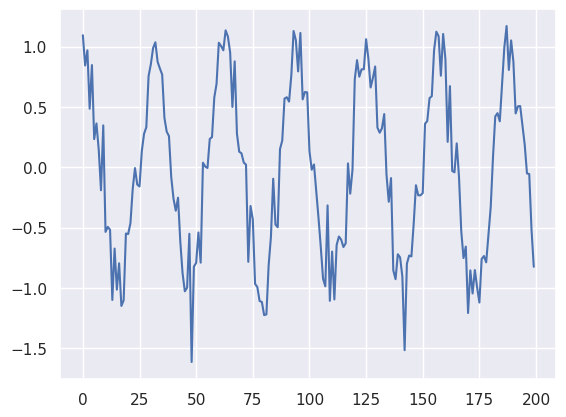

In [17]:
#set the random seed so that we all get the same results
np.random.seed(12)
t = np.arange(200)
ts_data = np.cos(0.2 * t)
noise = np.random.normal(loc=0.0, scale=0.2, size=200)
ts_data = ts_data + noise
plt.plot(ts_data);

In [18]:
WINDOW_SIZE = 12
BATCH_SIZE = 16

#preprocess time series into a supervised learning problem
X_data, y_data = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train test split
train_size = int(len(y_data) * (2/3))
X_train, X_test, y_train, y_test = ts_train_test_split(X_data, 
                                                y_data,
                                                train_size=train_size,
                                                as_tensors=True)

In [19]:
def fit(model, optimizer, criterion, n_epochs, 
        X_train, y_train, X_test=None, y_test=None, 
        batch_size=32, verbose=0):
    '''
    train the pytorch model 
    
    Parameters:
    ------
    model: torch.nn.module
        PyTorch Neural Network Model implements .forward()
    
    optimizer: torch.optim.Optimizer
        PyTorch optimization engine e.g. Adam
        
    criterion: torch.nn.criterion
        PyTorch criterion e.g. MSELoss 
        
    n_epochs: int
        Number of epochs to train
        
    X_train: Tensor
        x training matrix 2D
        
    y_train: Tensor
        y training vector
        
    X_test: Tensor, optional (default=None)
        x test matrix 2D
        
    y_test: Tensor, optional (default=None)
        y test vector
        
    batch_size: int, optional (default=32)
        Size of the mini batches used in training
        
    verbose: int, optional (default=0)
        0 == no output during training
        1 == output loss every 10 epochs 
        (includes validation loss if X_test, y_test included)
    
    Returns:
    -------
        dict
        training and validation loss history. keys are
        'loss' and 'val_loss'
    '''
    PRINT_STEPS = 10

    # Set up lists for loss
    train_losses = []
    test_losses = []

    history = {'loss':[],
               'val_loss':[]}

    #create the mini-batches
    train_loader = get_data_loader(X_train, 
                               y_train, 
                               batch_size=batch_size)
    start_time = time.time()
    
    # Loop through required number of epochs
    for epoch in range(n_epochs):
        # Train model (using batches): Switch to training mode
        model.train()
        for batch in train_loader:
            
            y_pred = model.forward(batch[0])
            loss = criterion(y_pred, batch[1].reshape(y_pred.shape[0], -1))

            # Zero gradients, perform a backward pass,  
            # and update the weights. 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

        # Get results for complete training set: Switch to evaluation mode
        model.eval()
        y_pred_train = model.forward(X_train)
        history['loss'].append(criterion(y_pred_train, 
                                         y_train.reshape(y_pred_train.shape[0], -1)).detach())

        if not X_test is None:
            # Get results for test set
            y_pred_test = model.forward(X_test)
            history['val_loss'].append(criterion(y_pred_test, 
                                                 y_test.reshape(y_pred_test.shape[0], -1)).detach())

        # Print loss & accuracy every 10 epochs (print last iteem of results lists)
        if verbose == 1:
            if (epoch+1) % PRINT_STEPS == 0:
                print(f'Epoch {epoch+1}. ', end='')
                print(f"Train accuracy {history['loss'][-1]: 0.3f}. ", end='')
                print(f"Test accuracy {history['val_loss'][-1]: 0.3f}.")

    duration = time.time() - start_time
    if verbose == 1:
        print(f'Training time {duration:.2f}s')
    
    return history

In [20]:
torch.manual_seed(1234)

# Create model
model = LinearModel(WINDOW_SIZE)
# Set loss 
criterion = nn.MSELoss()
# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
history = fit(model, optimizer, criterion, n_epochs=100, 
              X_train=X_train, y_train=y_train, 
              X_test=X_test, y_test=y_test, verbose=1)

Epoch 10. Train accuracy  0.062. Test accuracy  0.055.
Epoch 20. Train accuracy  0.057. Test accuracy  0.054.
Epoch 30. Train accuracy  0.055. Test accuracy  0.053.
Epoch 40. Train accuracy  0.054. Test accuracy  0.053.
Epoch 50. Train accuracy  0.053. Test accuracy  0.053.
Epoch 60. Train accuracy  0.053. Test accuracy  0.053.
Epoch 70. Train accuracy  0.053. Test accuracy  0.053.
Epoch 80. Train accuracy  0.053. Test accuracy  0.053.
Epoch 90. Train accuracy  0.053. Test accuracy  0.054.
Epoch 100. Train accuracy  0.053. Test accuracy  0.054.
Training time 0.06s


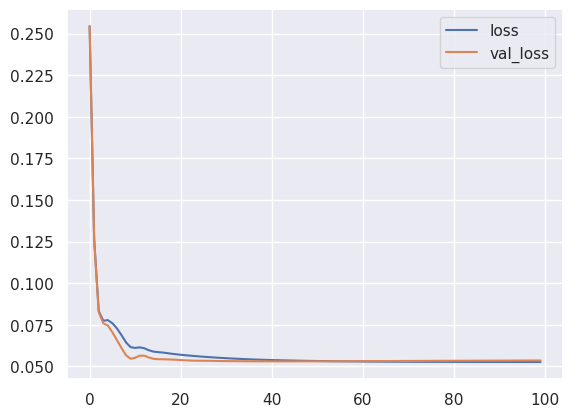

In [22]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend();

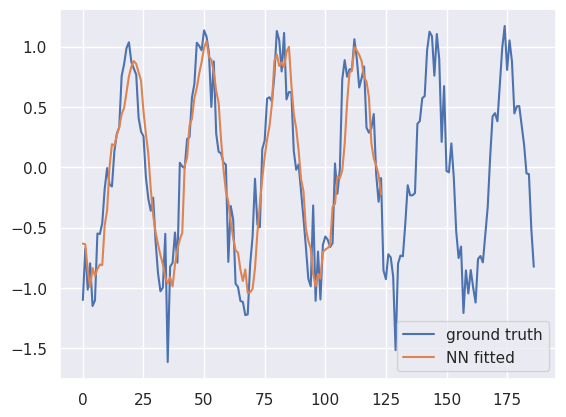

In [23]:
plt.plot(ts_data[WINDOW_SIZE+1:], label='ground truth')
plt.plot(model(X_train).detach().numpy(), label='NN fitted')
plt.legend();

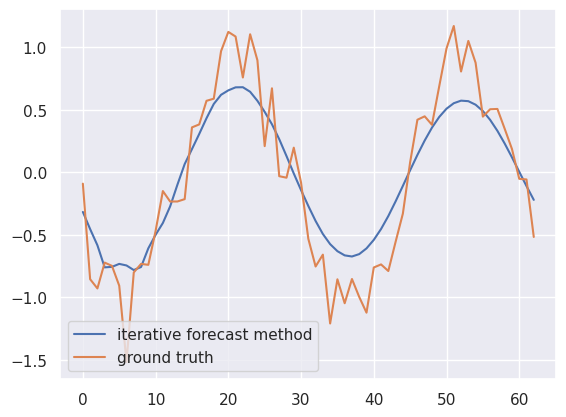

In [24]:
#make iterative predictions
H = len(y_test)
y_preds_iter = autoregressive_iterative_forecast(model, 
                                                 X_test[0], 
                                                 h=H)

#plot
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend();


##  2.5 The direct h-step forecasting method.

In the direct method to forecast h-steps ahead we have **$h$ forecasting models**.  Each model provides a single point forecast from a step ahead.  In the example here, y_test is of length 57 periods.  The direct method requires 57 NNs to make its prediction!


Recall the `sliding_window` function.  We ignored an optional parameter `horizon` in the iterative example.  By default `horizon=1` i.e. the function returns target values that are only a single period ahead.  We can vary the step size by increasing the value of horizon.  

**Training multiple models**

1. Create a for loop and set it to iterate 57 times. 
2. In each loop call `sliding_window` setting `horizon` to the iteration number + 1
3. Create a new instance of the the model
4. Train the model and save in a list.
5. Save the model to .h5 file. (recommended so you can reload without retraining)

In [25]:
def train_direct_models(data, n_epochs, horizon, window_size, 
                        train_size, save=True):

    models = []

    print('Training model =>', end=' ')
    for h in range(horizon):
        print(f'{h+1}', end=', ')

        # preprocess time series into a supervised learning problem
        X, y = sliding_window(data, window_size=window_size,
                              horizon=h+1)
        
        # train test split
        X_train, X_test, y_train, y_test = ts_train_test_split(X, y,
                                                        train_size=train_size,
                                                        as_tensors=True)
        # Create model
        model_h = LinearModel(window_size)
        # Set loss 
        criterion = nn.MSELoss()
        # Set optimizer
        optimizer = torch.optim.Adam(model_h.parameters(), lr=0.01)

        # fit model silently (verbose=0)
        history = fit(model_h, optimizer, criterion, n_epochs=100, 
                      X_train=X_train, 
                      y_train=y_train,
                      verbose=0)

        if save:
            path = f'./output/direct_model_h{h+1}.pt'
            torch.save(model_h.state_dict(), path)

        models.append(model_h)

    print('done')
    return models

In [26]:
def load_linear_direct_models(horizon, ws):
    models = []
    print('Loading direct model horizon =>', end=' ')
    for h in range(horizon):
        print(f'{h+1},', end=' ')
        model_h = LinearModel(ws)
        path = f'./output/direct_model_h{h+1}.pt'
        model_h.load_state_dict(torch.load(path))
        model_h.eval()
        models.append(model_h)
    return models

In [27]:
# set pytorch random seed
torch.manual_seed(1234)

N_EPOCHS = 100
HORIZON = len(y_test)
WINDOW_SIZE = 12
TRAIN_SIZE = 130
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    direct_models = load_linear_direct_models(HORIZON, 
                                              WINDOW_SIZE)
else:
    direct_models = train_direct_models(ts_data, 
                                        n_epochs=N_EPOCHS,
                                        horizon=HORIZON, 
                                        window_size=WINDOW_SIZE, 
                                        train_size=TRAIN_SIZE)

Loading direct model horizon => 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 

We now create the `direct_forecast` function.  This is just a for loop to pass the input X data each model.  Remember that the input to each model is **same** i.e. exog which in our case will be `X_test[0]`

In [28]:
def direct_forecast(models, exog):
    '''
    h-step forecast for an autoregressive 
    model using the direct prediction method.
    
    Each model contained in @models has been trained
    to predict a unique number of steps ahead. 
    Each model forecasts and the results are 
    combined in an ordered array and returned.
    
    Parameters:
    ------
    models: list
        direct models each has has a .predict(exog) 
        interface
        
    exog: Tensor
        initial vector of lagged values (X)
        
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    preds = []
    for model_h in models:
        with torch.no_grad():
            pred_h = model_h(exog)[0]
        preds.append(pred_h)
    
    return np.array(preds)

In [29]:
# make the direct forecast
y_preds_direct = direct_forecast(direct_models, X_test[0])

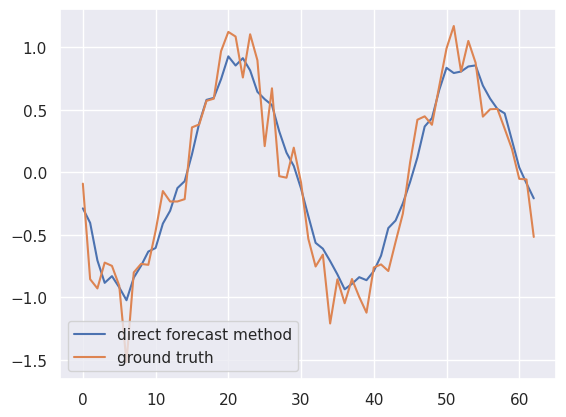

In [30]:
# plot the direct forecast against the test data
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

Like the iterative method the direct method looks a close match to the ground truth test set!  Let's plot all three datasets on the same chart and then take a look at the **RMSE** of each method.

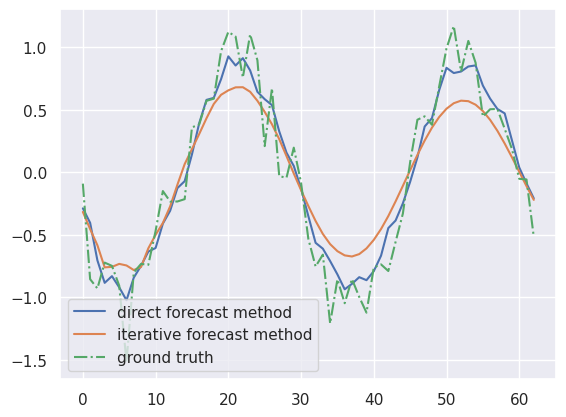

In [31]:
# plot iterative and direct
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth', linestyle='-.')
plt.legend()

In [32]:
from forecast_tools.metrics import root_mean_squared_error

In [33]:
root_mean_squared_error(y_test, y_preds_iter)

0.29311162

In [34]:
root_mean_squared_error(y_test, y_preds_direct)

0.20051152

In this particular example (and single holdout set) the direct method out performed the iterative method. You should not assume this is always the case!

## 2.6 Forecasting a vector of y

In the **iterative** and **direct** methods we always forecast a *scalar* value.  An modification is to adapt a feedforward neural network to predict a **vector of y values**.  Using this architecture we would train our model on sliding windows of $X$ and $y$.  Where y is a vector of length $h$ and $X$ is a vector of length $ws$ (window size)

### 2.6.1 Exercise: preprocessing the time series into vectors of y
Task: modify the function `sliding_window` (provided below) so that it returns a vectors of y.

Hints:
* Assume you are standing at time $t$. With a forecasting horizon of $h$, y would be $[y_{t+1}, y_{t+2}, ... , y_{t+h}]$.
* Array slicing might prove useful:

```python
train = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(train[2:6])
```
```
>> [3 4 5 6]
```

In [35]:
def sliding_window(train, window_size=2, horizon=2):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=2)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        #we use list slicing to return a vector of training for y_train
        y_train = train[i+window_size:i+window_size+horizon]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.array(tabular_y)

**After** you have modified `sliding_window` run the code below to preprocess the time series.

## 2.6.2 Build a model that predicts vectors in PyTorch

In [36]:
# Base model on PyTorch nn.Module class
class VectorModel(nn.Module):
    def __init__(self, in_features, n_neurons, n_outputs):
        # Inherit parent (nn.module) methods using super init
        super(VectorModel, self).__init__()
        
        # This time we have two Linear layers
        
        # The first layer maps input features to a second layer
        # with user specified number of neurons.
        self.layer1 = nn.Linear(in_features=in_features, 
                                out_features=n_neurons, 
                                bias=True)
        
        # The output layer has a user specified n_outputs
        # This is equal to the horizon you are predicting.
        self.out = nn.Linear(in_features=n_neurons,
                             out_features=n_outputs,
                             bias=True)
        
    def forward(self, x):
        # Pass data through net. 
        x = F.relu(self.layer1(x))
        y_pred = self.out(x)
        return y_pred

### 2.6.3 Train the model

In [37]:
# set PyTorch random seed
torch.manual_seed(1234)

WINDOW_SIZE = 12
HORIZON = 12
N_EPOCHS = 100
TRAIN_SIZE = 130
BATCH_SIZE = 32

# convert time series to supervised learning format
X, y = sliding_window(ts_data, 
                      window_size=WINDOW_SIZE,
                      horizon=HORIZON)

#train-test split
X_train, X_test, y_train, y_test = ts_train_test_split(X, y,
                                                       train_size=TRAIN_SIZE,
                                                       as_tensors=True)

# Create an instance of VectorModel
model_v = VectorModel(WINDOW_SIZE, n_neurons=10, n_outputs=HORIZON)
# Set loss function
criterion = nn.MSELoss()
# Set optimizer to Adam
optimizer = torch.optim.Adam(model_v.parameters(), lr=0.01)

# train the model
history = fit(model_v, optimizer, criterion, N_EPOCHS, X_train, y_train)

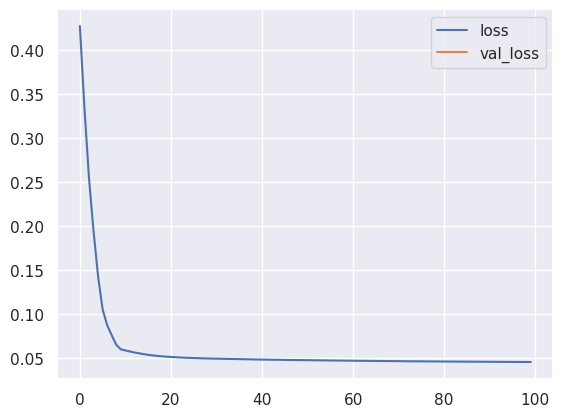

In [38]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

### 2.6.4 Predict a single vector ahead.

Predicting a single vector ahead is actually making a h-step forecast.  This is done in exactly the same way as the other models using `.predict(X)`

In [39]:
with torch.no_grad():
    y_preds = model_v(X_test[0])
y_preds.numpy()

array([-0.85863626, -1.059653  , -0.79760617, -0.72446626, -0.63018465,
       -0.45190078, -0.22423315, -0.18300961, -0.0080177 ,  0.17726624,
        0.35812086,  0.49889594], dtype=float32)

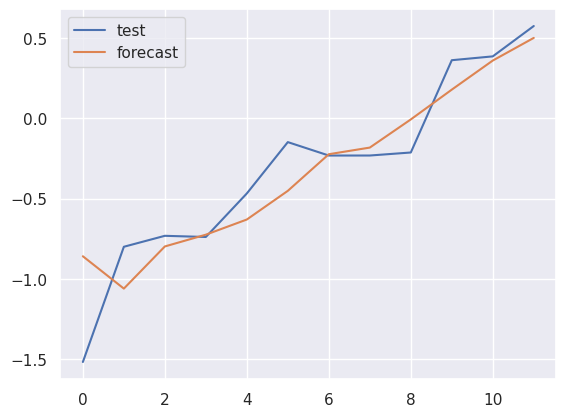

In [40]:
#plot the prediction
plt.plot(y_test[0], label='test')
plt.plot(y_preds, label='forecast')
plt.legend()

### 2.6.5 Exercise predicting multiple vectors ahead (> h-steps)

It is important to remember that with the vector output you predict in multiples of $h$.  So if you make two predictions you have predictions for 2h.  But in general this works in the same way as the iterative method.  Each time you forecast you replace $h$ values in the X vector with the predictions.

**Task**: 
* Modify `autoregressive_iterative_forecast` (provided below) so that it works with the new model.  After you are done rename the function `vector_iterative_forecast`
* Predict 4 vector lengths ahead and plot the result against the test set.

Hints:

* For simplicity, you could make the parameter `h` the number of vectors ahead to predict.
* Each call of `model(X)` returns a vector.  At the end of the iterative forecast you will have a list of vectors.  Call `np.concatenate(list)` to transform this into a single list.
* In the notebook the X and vectors are both of size 12 (`WINDOW_SIZE == 12` and `len(y_train[0]) == 12`). This means you could simplify your code for the example.  Alternatively it could work with different sized X and y vectors. 
* Remember that `y_test` contains sliding windows of size 12.  So if you predict 2 vectors ahead then you will need to plot `y_test[0]` and `y_test[12]`




In [41]:
def vector_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        with torch.no_grad():
            y_pred = model(current_X)
            
        y_preds.append(y_pred.numpy())
        
        #current_X = np.roll(current_X, shift=-h)
        #current_X[-h] = y_pred.copy()
        #in pytorch we use clone() method 
        current_X = y_pred.clone()

    return np.concatenate(np.array(y_preds))

In [42]:
H = 4
y_preds = vector_iterative_forecast(model_v, X_test[0], H)
y_preds

array([-0.85863626, -1.059653  , -0.79760617, -0.72446626, -0.63018465,
       -0.45190078, -0.22423315, -0.18300961, -0.0080177 ,  0.17726624,
        0.35812086,  0.49889594,  0.64681923,  0.63836235,  0.80317575,
        0.9380151 ,  0.8499751 ,  0.8499375 ,  0.8107167 ,  0.6725296 ,
        0.5154017 ,  0.34813106,  0.20761925,  0.05103193, -0.07836662,
       -0.38591772, -0.34450367, -0.4582504 , -0.71375823, -0.73479295,
       -0.78407073, -0.8771061 , -0.9213152 , -0.91942954, -0.7406444 ,
       -0.7046767 , -0.5737956 , -0.41885212, -0.23791128, -0.08701344,
        0.01845498,  0.23104993,  0.35890204,  0.48831028,  0.67162555,
        0.82048416,  0.91551393,  0.8810459 ], dtype=float32)

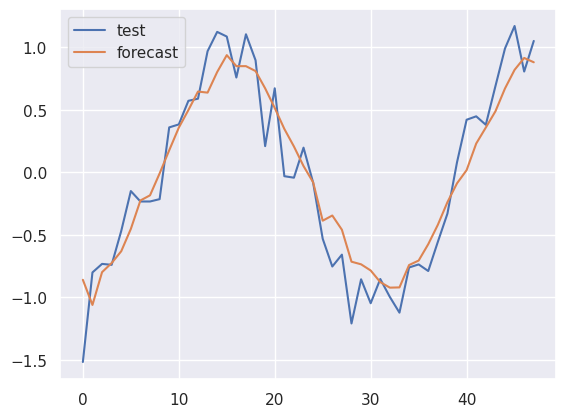

In [43]:
y_test_to_plot = []
for i in range(H):
    y_test_to_plot.append(y_test[WINDOW_SIZE*i].numpy())

plt.plot(np.concatenate(y_test_to_plot), label='test')
plt.plot(y_preds, label='forecast')
plt.legend()